All code based on:
https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=2

In [1]:
data_path = 'data/'

words = open(f'{data_path}names.txt').read().splitlines()

In [2]:
words[0:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

# Bigram statistics

In [3]:
import torch
from matplotlib import pyplot as plt

tensor_counts = torch.zeros((27, 27), dtype = torch.int32)
chars = list(set(''.join(words)))
chars = ['.'] + chars
char_index_map = {s:i for i, s in enumerate(chars)}

#bigram_counts = {}

for w in words:
    characters = ['.'] + list(w) + ['.']
    for c1, c2 in zip(characters, characters[1:]):
        tensor_counts[char_index_map[c1], char_index_map[c2]] += 1
        # bigram_counts[bigram] = bigram_counts.get(bigram, 0) + 1

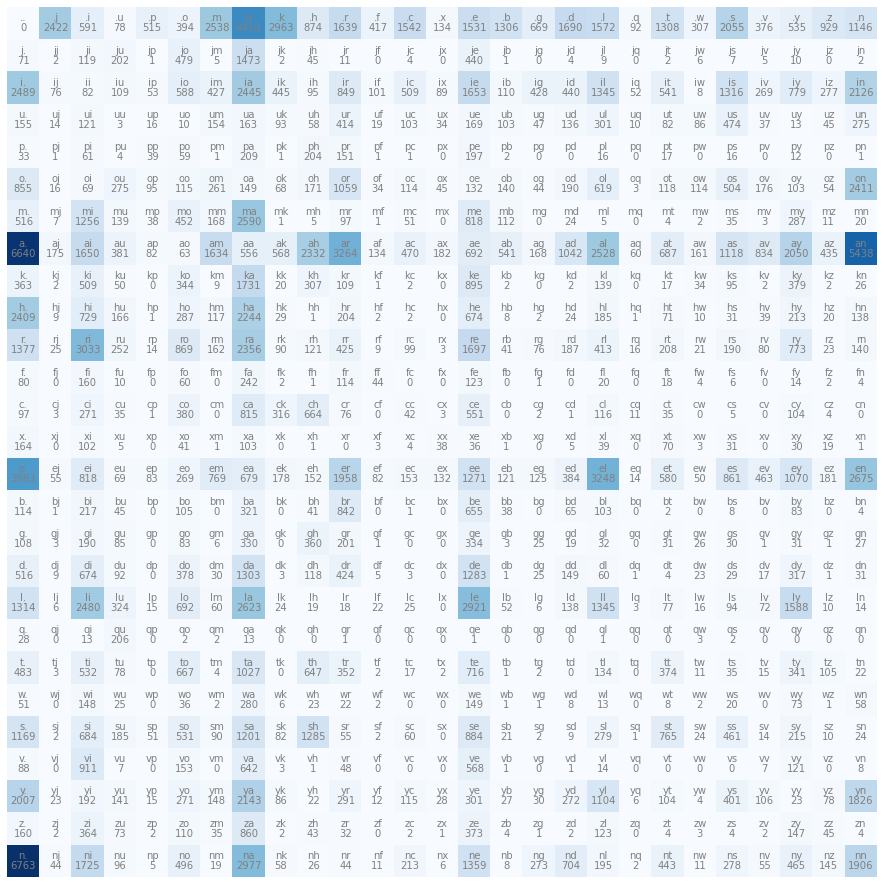

In [4]:
plt.figure(figsize=(16, 16))
plt.imshow(tensor_counts, cmap = 'Blues')
for i in range(len(chars)):
    for j in range(len(chars)):
        string = chars[i] + chars[j]
        plt.text(j, i, string, ha = 'center', va = 'bottom', color = 'gray')
        plt.text(j, i, tensor_counts[i,j].item(), ha = 'center', va = 'top', color = 'gray')
plt.axis('off')
plt.show()

# Generating names using bigram probabilities

In [26]:
def generate_words(tensor_counts, number_words):   
    generator = torch.Generator().manual_seed(42)
    P = (tensor_counts+1).float() # The 1 is a regulator
    P = P / P.sum(dim = 1, keepdim = True)

    out = []

    for i in range(number_words):
        string = ''
        character = '.'
        done = False

        while not done:
            current_char_idx = char_index_map[character]

            # Next character probability distribution
            p = P[current_char_idx]

            # Sample one:
            random_idx = torch.multinomial(p, num_samples=1, replacement=True, generator=generator).item()
            character = chars[random_idx]
            if character == '.':
                done = True
            else:
                # Add to name
                string = string + character


        out.append(string)

    return out

new_words = generate_words(tensor_counts, 30)

new_words

['ji',
 'jaryn',
 'mikenid',
 'dro',
 'gam',
 'je',
 'a',
 'aiaaley',
 'ary',
 'kansa',
 'bree',
 'een',
 'kh',
 'jaularancolya',
 'b',
 'ch',
 'alalinn',
 'd',
 'une',
 'ryabr',
 'zahrathorala',
 'jiman',
 'zaliahremh',
 'jenoe',
 'yayli',
 'briaerarrilerashrroanursenna',
 'bysto',
 'jirkahayose',
 'dala',
 'ekuson']

# Log likelihood

# 

In [27]:
def compute_loglikelihood(ws, tensor_counts = tensor_counts, char_index_map = char_index_map):

    P = tensor_counts.float()
    P = P / P.sum(dim = 1, keepdim = True)

    log_likelihood = 0.0
    n = 0

    for w in ws:
        characters = ['.'] + list(w) + ['.']
        for c1, c2 in zip(characters, characters[1:]):
            prob = P[char_index_map[c1], char_index_map[c2]]
            logprob = torch.log(prob)
            log_likelihood += logprob
            n += 1
    
    return log_likelihood / n


nll = - compute_loglikelihood(words)

print('Loss = negative log likelihood for the training set: ')
print(f'{nll=}')


Loss = negative log likelihood for the training set: 
nll=tensor(2.4541)


In [28]:
new_nll = - compute_loglikelihood(new_words)
print('Loss = negative log likelihood for the outcome: ')
print(f'{new_nll=}')

Loss = negative log likelihood for the outcome: 
new_nll=tensor(2.4372)


# NN model

Input: character

Output: Probability distribution over next characters

In [69]:
import torch.nn.functional as F

# Training set
def generate_training_set(words):
    X, Y = [], []

    for w in words:
        characters = ['.'] + list(w) + ['.']
        for c1, c2 in zip(characters, characters[1:]):
            idx1, idx2 = char_index_map[c1], char_index_map[c2]
            X.append(idx1)
            Y.append(idx2)
    # Each character corresponds to an integer index
    X, Y = torch.tensor(X), torch.tensor(Y)
    # Need to one-hot encode these as 27-dimensional vectors (26 chars + .)
    X = F.one_hot(X, num_classes = 27).float()
    # Now input is a 27 dim vector, and so is the output. 
    # The predictive output will be normalized and will stand for probabilities
    return X, Y


# X, Y will be of dimensions (n_samples, 27)
X, Y = generate_training_set(words)


# Weights of the neuron
W = torch.randn((27, 27), requires_grad = True)

# X times W will be (n_samples, 27)
# apply exp to make all positive
# Normalize to get probabilities
logits = X @ W
logcounts = logits.exp()
prob = logcounts / logcounts.sum(dim = 1, keepdims = True)

In [70]:
prob

tensor([[0.0074, 0.0165, 0.0190,  ..., 0.0096, 0.0435, 0.2204],
        [0.0512, 0.0022, 0.0196,  ..., 0.0166, 0.0576, 0.0117],
        [0.0261, 0.0096, 0.0378,  ..., 0.0126, 0.0099, 0.0079],
        ...,
        [0.0115, 0.0130, 0.0112,  ..., 0.0836, 0.0386, 0.0247],
        [0.0325, 0.0719, 0.0163,  ..., 0.0344, 0.0508, 0.0516],
        [0.0703, 0.0488, 0.0198,  ..., 0.0155, 0.0488, 0.0186]],
       grad_fn=<DivBackward0>)

In [71]:
prob.shape

torch.Size([228146, 27])

In [72]:
# Loss

nll = - prob[torch.arange(prob.shape[0]), Y].log().mean()

nll

tensor(3.8033, grad_fn=<NegBackward0>)

In [92]:
# backward pass
W.grad = None
nll.backward()

In [93]:
W.data += -0.1 * W.grad

In [94]:
logits = X @ W
logcounts = logits.exp()
prob = logcounts / logcounts.sum(dim = 1, keepdims = True)
nll = - prob[torch.arange(prob.shape[0]), Y].log().mean()


nll

tensor(3.7970, grad_fn=<NegBackward0>)

In [99]:
episodes = 100
lr = 50
regularization_coef = 0.1

for i in range(episodes):
    # backward pass
    W.grad = None
    nll.backward()

    # update 
    W.data += - lr * W.grad

    # loss
    logits = X @ W
    logcounts = logits.exp()
    prob = logcounts / logcounts.sum(dim = 1, keepdims = True)
    nll = - prob[torch.arange(prob.shape[0]), Y].log().mean() + regularization_coef * (W**2).mean()

    loss = nll.item()

    print(f'Loss: {loss}')


Loss: 2.4999287128448486
Loss: 2.4987542629241943
Loss: 2.497633934020996
Loss: 2.4965646266937256
Loss: 2.4955434799194336
Loss: 2.494567632675171
Loss: 2.4936342239379883
Loss: 2.4927408695220947
Loss: 2.4918856620788574
Loss: 2.4910662174224854
Loss: 2.4902803897857666
Loss: 2.4895265102386475
Loss: 2.488802433013916
Loss: 2.4881069660186768
Loss: 2.487438440322876
Loss: 2.486794948577881
Loss: 2.486175775527954
Loss: 2.485579490661621
Loss: 2.4850046634674072
Loss: 2.484449863433838
Loss: 2.483914852142334
Loss: 2.483398199081421
Loss: 2.4828994274139404
Loss: 2.4824166297912598
Loss: 2.481950044631958
Loss: 2.4814982414245605
Loss: 2.481060743331909
Loss: 2.4806368350982666
Loss: 2.4802253246307373
Loss: 2.4798271656036377
Loss: 2.479440212249756
Loss: 2.479064464569092
Loss: 2.4786994457244873
Loss: 2.478344678878784
Loss: 2.4779999256134033
Loss: 2.4776644706726074
Loss: 2.4773380756378174
Loss: 2.477020263671875
Loss: 2.476710557937622
Loss: 2.4764089584350586
Loss: 2.476115703

# Predicting using NN

In [105]:
def generate_words_nn(W, number_words):   
    generator = torch.Generator().manual_seed(42)
    out = []

    for i in range(number_words):
        string = ''
        character = '.'
        done = False

        while not done:
            current_char_idx = char_index_map[character]

            # Next character probability distribution
            Xin = F.one_hot(torch.tensor([current_char_idx]), num_classes= 27).float()
            logits = Xin @ W
            logcounts = logits.exp()
            p = logcounts / logcounts.sum(dim = 1, keepdims = True)
            
            # Sample one:
            random_idx = torch.multinomial(p, num_samples=1, replacement=True, generator=generator).item()
            character = chars[random_idx]
            if character == '.':
                done = True
            else:
                # Add to name
                string = string + character


        out.append(string)

    return out

new_words = generate_words_nn(W, 30)

new_words

['jum',
 'fann',
 'mikenid',
 'dro',
 'gam',
 'je',
 'a',
 'aiaaley',
 'ary',
 'kanwa',
 'bree',
 'een',
 'kh',
 'jaularancolya',
 'b',
 'ch',
 'alalinn',
 'd',
 'une',
 'ryabr',
 'zahrathorala',
 'jiman',
 'zaliahch',
 'li',
 'star',
 'yayli',
 'briaerarrilerashrroanursenna',
 'bystmi',
 'jalahayose',
 'dala']